In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [5]:
data = pd.read_csv("resources/Frozen_Dessert_Production.csv", index_col="DATE", parse_dates = True)

In [7]:
data.columns = ["sales"]

In [10]:
data.head()

,sales
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [11]:
len(data)

573

In [12]:
573/12

47.75

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


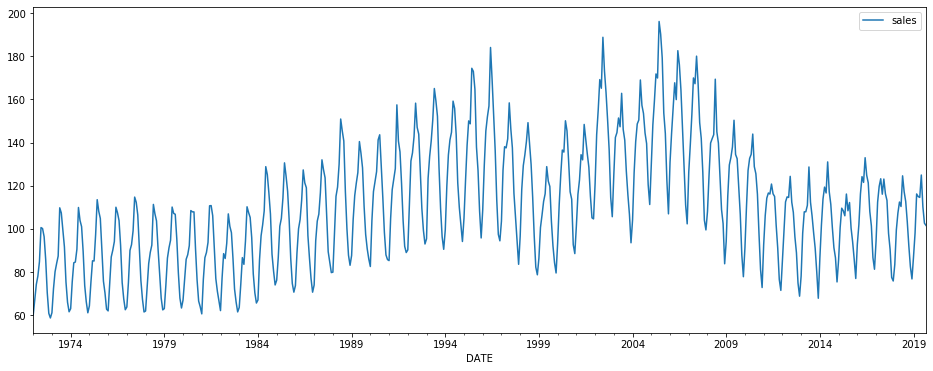

In [9]:
data.plot(figsize = (16,6))

## Data sample
- 10 years of data out of the almost 50 years of data
- so 120 months

In [15]:
test_sample = 120

In [16]:
test_index = len(data) - test_sample

In [17]:
train = data.iloc[:test_index]

In [18]:
test = data.iloc[test_index:]

In [20]:
train.shape

(453, 1)

In [21]:
test.shape

(120, 1)

### Scaling the data

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
scalar = MinMaxScaler()

In [24]:
trained_scaled = scalar.fit_transform(train)

In [25]:
test_scaled = scalar.transform(test)

### Setting Time Series and length

In [26]:
length = 6

In [27]:
generator = tf.keras.preprocessing.sequence.TimeseriesGenerator

In [28]:
time_gen = generator(
    trained_scaled,
    trained_scaled,
    length=length,
    batch_size=1,
)

## Testing generator

In [30]:
X,y = time_gen[0]

In [31]:
X

array([[[0.00947104],
        [0.06108982],
        [0.11326273],
        [0.14145625],
        [0.18982663],
        [0.30495972]]])

In [32]:
y

array([[0.30154406]])

## Eval

In [33]:
trained_scaled[length]

array([0.30154406])

### Early stopping

In [35]:
stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)

In [36]:
val_gen = generator(test_scaled,test_scaled, batch_size=1, length=length)

#### Model Creation 

In [38]:
from tensorflow.keras.layers import LSTM, Dense

In [39]:
n_features = 1

In [42]:
model = tf.keras.models.Sequential()
model.add(LSTM(units = 200, activation = "relu", input_shape = (length, n_features)))
model.add(Dense(units = 1))
model.compile(loss = "mse", optimizer = "adam")

## Fitting model 

In [43]:
model.fit_generator(time_gen, validation_data=val_gen, epochs=10, callbacks=[stop])

Epoch 1/10
447/447 [==============================] - 119s 266ms/step - loss: 0.0303 - val_loss: 0.0196
Epoch 2/10
447/447 [==============================] - 122s 273ms/step - loss: 0.0155 - val_loss: 0.0063
Epoch 3/10
447/447 [==============================] - 128s 286ms/step - loss: 0.0105 - val_loss: 0.0043
Epoch 4/10
447/447 [==============================] - 123s 275ms/step - loss: 0.0072 - val_loss: 0.0056
Epoch 5/10
447/447 [==============================] - 123s 275ms/step - loss: 0.0063 - val_loss: 0.0041
Epoch 6/10
447/447 [==============================] - 139s 311ms/step - loss: 0.0054 - val_loss: 0.0059
Epoch 7/10
447/447 [==============================] - 129s 289ms/step - loss: 0.0052 - val_loss: 0.0035
Epoch 8/10
447/447 [==============================] - 122s 273ms/step - loss: 0.0051 - val_loss: 0.0041
Epoch 9/10
447/447 [==============================] - 133s 298ms/step - loss: 0.0049 - val_loss: 0.0035
Epoch 10/10
447/447 [==============================] - 128s 286m

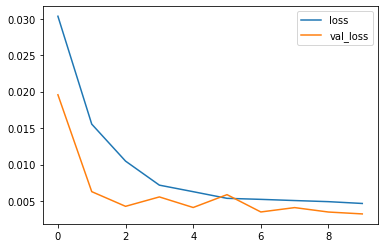

In [45]:
pd.DataFrame(model.history.history).plot()

### PRedictions

In [47]:
test_predictions = []
test_batch = test_scaled[-length:]
current_Batch = test_batch.reshape((1,length,n_features))

for i in range(len(test)):
    prediciton = model.predict(current_Batch)[0]
    test_predictions.append(prediciton)
    current_Batch = np.append(current_Batch[:,1:,:], [[prediciton]], axis =1 )

In [49]:
true_predictions = scalar.inverse_transform(test_predictions)

In [52]:
test["prediciton"] = true_predictions

/Users/berkatbhatti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### model somewhat pickes up the tends in the first few months 

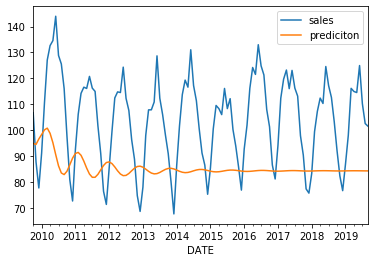

In [54]:
test.plot()

In [55]:
fullScalar = MinMaxScaler()

In [56]:
data_scaled = fullScalar.fit_transform(data)

In [57]:
data_gen = generator(data_scaled, data_scaled, length= length, batch_size=1)

### Forecast

In [ ]:
forecast = []
periods = length
batchh = 